<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/5_Find_Best_Traffic_Flow_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In this code file, we use only the traffic flow data that were generated under the SPQ rules.

In [ ]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [ ]:
# Access google drive location
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path with the data that we are interested in
PATH = 'traffic_flow_SPQ.csv'

**Prepare the dataset**

In [ ]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [ ]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-06-10 04:30:04,2008-06-10 05:00:04,2008-06-10 05:30:04,2008-06-10 06:00:04,2008-06-10 06:30:04,2008-06-10 07:00:04,2008-06-10 07:30:04,2008-06-10 08:00:04,2008-06-10 08:30:04,2008-06-10 09:00:04
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,11,7,6,3,0,1,...,0,0,0,0,0,0,2,2,0,0


In [ ]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

In [ ]:
# Convert 'Path' column to numerical
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [ ]:
# Print dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
67,108,5,0,20,2008-05-17 10:00:04,0
167,108,5,0,20,2008-05-17 10:30:04,0
267,108,5,0,20,2008-05-17 11:00:04,0
367,108,5,0,20,2008-05-17 11:30:04,1
467,108,5,0,20,2008-05-17 12:00:04,0
...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0
114735,168,547,99,2,2008-06-10 07:30:04,0
114835,168,547,99,2,2008-06-10 08:00:04,1
114935,168,547,99,2,2008-06-10 08:30:04,0


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [ ]:
### Extract timestamp information to different columns ###
traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###
traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [ ]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [ ]:
# Print traffic_flow dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,dayofweek,day,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
67,108,5,0,20,2008-05-17 10:00:04,0,10,5,17,0,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
167,108,5,0,20,2008-05-17 10:30:04,0,10,5,17,30,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
267,108,5,0,20,2008-05-17 11:00:04,0,11,5,17,0,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
367,108,5,0,20,2008-05-17 11:30:04,1,11,5,17,30,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
467,108,5,0,20,2008-05-17 12:00:04,0,12,5,17,0,1.224647e-16,-1.000000,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0,7,1,10,0,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114735,168,547,99,2,2008-06-10 07:30:04,0,7,1,10,30,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3
114835,168,547,99,2,2008-06-10 08:00:04,1,8,1,10,0,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114935,168,547,99,2,2008-06-10 08:30:04,0,8,1,10,30,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3


In [ ]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-06-10 09:00:04


#### **Make Visualizations**


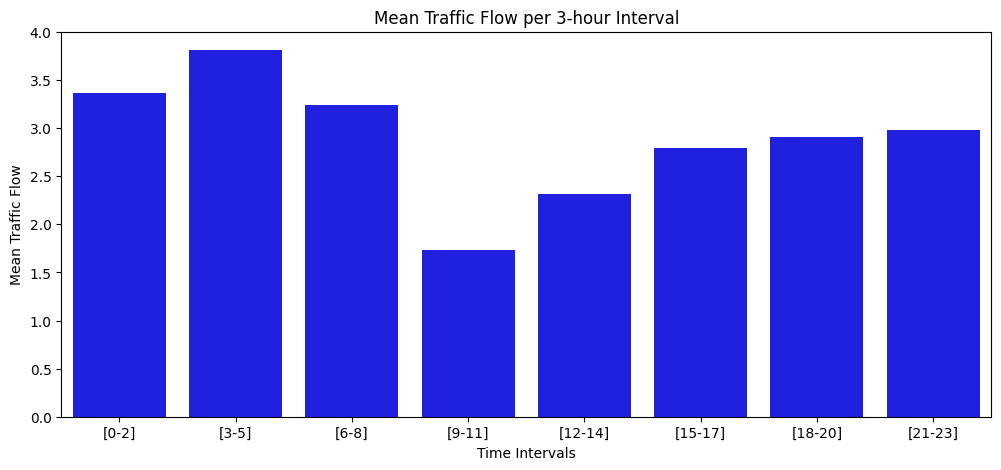

In [ ]:
# Group by 3hour_interval and calculate the mean of the traffic flow
grouped_df = traffic_flow['Traffic Flow'].groupby(traffic_flow['3hour_interval']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Define the intervals (use strings for easy understanding)
intervals = ['[0-2]','[3-5]','[6-8]','[9-11]','[12-14]','[15-17]','[18-20]','[21-23]']
grouped_df['Hour Interval'] = intervals

# Create a plot to view the results
plt.figure(figsize=(12,5))
sns.barplot(grouped_df, x='Hour Interval', y='Traffic Flow', color='blue')
plt.xlabel('Time Intervals')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per 3-hour Interval')

# Show graph
plt.show()

The graph suggests that traffic flow peaks during morning and evening hours, while it tends to be lower during noon.

Text(0.5, 1.0, 'Mean Traffic Flow per Day of Week')

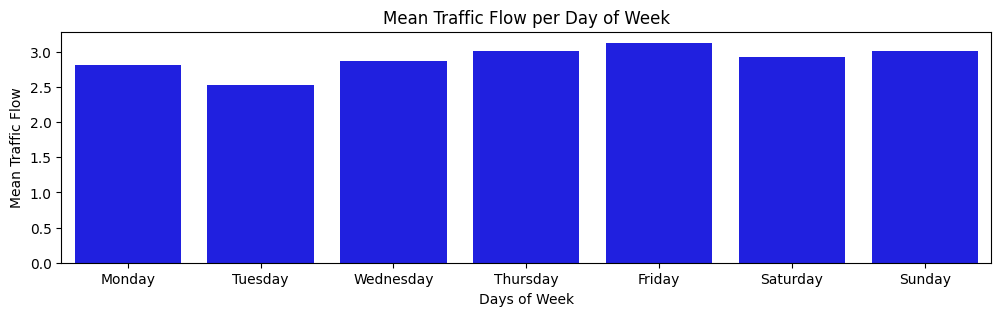

In [ ]:
# Group by dayofweek and calculate the mean of the traffic flow
grouped_df = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['dayofweek']).mean())
grouped_df['Days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(grouped_df,x='Days',y='Traffic Flow',color='blue')
plt.xlabel('Days of Week')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per Day of Week')

Text(0.5, 1.0, 'Mean Traffic Flow during  Memorial Day (26th of May 2008)')

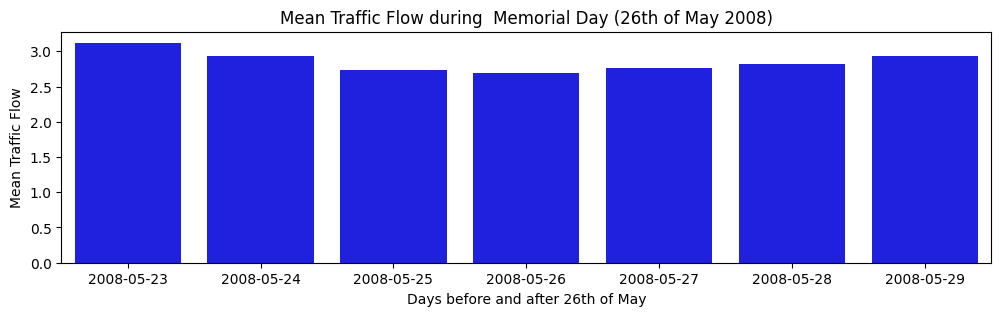

In [ ]:
# Select data within the specified date range
select_data = traffic_flow[(traffic_flow['Time Column'] >= '2008-05-23') & (traffic_flow['Time Column'] < '2008-05-30')]
# Extract the date portion from the 'Time Column' and create a new 'Date' column
select_data['Date'] = select_data['Time Column'].dt.date
# Create a DataFrame by grouping 'Traffic Flow' by 'Date' and calculating the sum
select_data = pd.DataFrame(select_data['Traffic Flow'].groupby(select_data['Date']).mean())

# Create a plot to visualize the results
plt.figure(figsize=(12, 3))  # Set the size of the plot figure
sns.barplot(data=select_data, x=select_data.index, y='Traffic Flow',color='blue')
plt.xlabel('Days before and after 26th of May')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow during  Memorial Day (26th of May 2008)')

According to the calendar, Memorial Day in the United States fell on May 26, 2008. The graph above indicates that on this particular day, there was a decrease in traffic flow, while the subsequent days showed higher traffic flow.

On Memorial Day, many businesses are closed, schools may be out, and people often take the opportunity to engage in various leisure activities or travel. As a result, there tends to be a decrease in local commuting and traffic flow on that specific day compared to the surrounding days.

<Axes: >

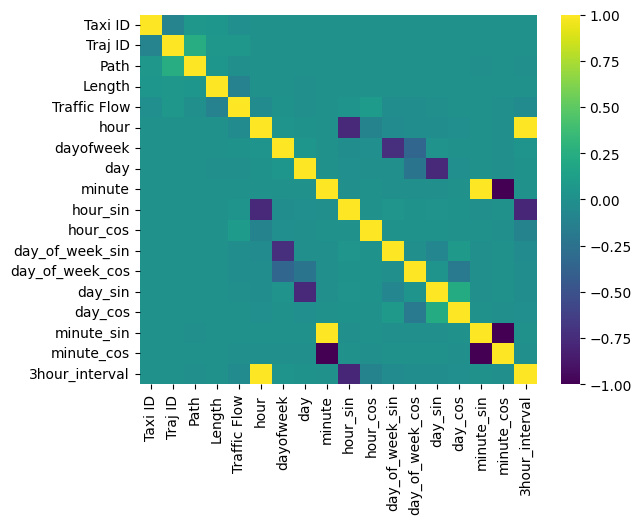

In [ ]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(traffic_flow.corr(),cmap='viridis')

In [ ]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Traffic Flow', 'hour', 'dayofweek', 'day', 'minute']

#### **Find the Optimum Sliding Window Length**

In [ ]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [ ]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Import libraries to use the LSTM Neural Network algorithm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Use Regression Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

##### Sliding Window Length Equals to 2

In [ ]:
# Define Window Length
lookback = 2

In [ ]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [ ]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [ ]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [ ]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [ ]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [ ]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.58382	validation_1-rmse:4.66060
[1]	validation_0-rmse:4.26528	validation_1-rmse:4.33909
[2]	validation_0-rmse:3.98807	validation_1-rmse:4.05813
[3]	validation_0-rmse:3.74620	validation_1-rmse:3.81406
[4]	validation_0-rmse:3.53596	validation_1-rmse:3.60031
[5]	validation_0-rmse:3.36535	validation_1-rmse:3.42761
[6]	validation_0-rmse:3.20976	validation_1-rmse:3.26959
[7]	validation_0-rmse:3.07585	validation_1-rmse:3.13340
[8]	validation_0-rmse:2.96060	validation_1-rmse:3.01560
[9]	validation_0-rmse:2.86838	validation_1-rmse:2.92132
[10]	validation_0-rmse:2.78551	validation_1-rmse:2.83525
[11]	validation_0-rmse:2.72041	validation_1-rmse:2.76847
[12]	validation_0-rmse:2.66618	validation_1-rmse:2.71277
[13]	validation_0-rmse:2.62096	validation_1-rmse:2.66636
[14]	validation_0-rmse:2.57925	validation_1-rmse:2.62210
[15]	validation_0-rmse:2.54658	validation_1-rmse:2.58809
[16]	validation_0-rmse:2.51937	validation_1-rmse:2.56006
[17]	validation_0-rmse:2.49785	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [ ]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [ ]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [ ]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3210858367196885
RMSE score: 2.324532025999567


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [ ]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [ ]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [ ]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 8s 33ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 2/50
100/100 [==============================] - 12s 119ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 11s 116ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/50
100/100 [==============================] - 11s 115ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 11s 116ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 12s 125ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/50
100/100 [==============================] - 11s 115ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/50
100/100 [==============================] - 12s 118ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/50
100/100 [==============================] - 13s 135ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 10/50
100/100 [==============================] - 13s 126ms/step - los

In [ ]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1104/1104 [==============================] - 15s 14ms/step - loss: 0.0011
Test Loss: 0.0011410346487537026


In [ ]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1104/1104 [==============================] - 9s 7ms/step


Evaluate the LSTM model

In [ ]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.4042629836993583
RMSE LSTM score: 2.364543466226621


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [ ]:
# Create dataframe with scores (length == 2)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [ ]:
scores # length is 2

,Model,RMSE Score,MAE Score
0,XGBoost,2.324532,1.321086
1,LSTM,2.364543,1.404263


In [ ]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [ ]:
# Save the LSTM model
model.save("LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length Equals to 3

In [ ]:
# Define Window Length
lookback = 3

In [ ]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [ ]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [ ]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [ ]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [ ]:
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.58742	validation_1-rmse:4.65899
[1]	validation_0-rmse:4.27097	validation_1-rmse:4.34019
[2]	validation_0-rmse:3.99241	validation_1-rmse:4.05699
[3]	validation_0-rmse:3.76240	validation_1-rmse:3.82512
[4]	validation_0-rmse:3.55221	validation_1-rmse:3.61216
[5]	validation_0-rmse:3.37643	validation_1-rmse:3.43383
[6]	validation_0-rmse:3.22439	validation_1-rmse:3.27922
[7]	validation_0-rmse:3.08795	validation_1-rmse:3.14226
[8]	validation_0-rmse:2.97259	validation_1-rmse:3.02481
[9]	validation_0-rmse:2.87790	validation_1-rmse:2.92803
[10]	validation_0-rmse:2.79289	validation_1-rmse:2.84097
[11]	validation_0-rmse:2.72085	validation_1-rmse:2.76915
[12]	validation_0-rmse:2.66090	validation_1-rmse:2.70798
[13]	validation_0-rmse:2.60874	validation_1-rmse:2.65377
[14]	validation_0-rmse:2.56480	validation_1-rmse:2.60930
[15]	validation_0-rmse:2.52812	validation_1-rmse:2.57065
[16]	validation_0-rmse:2.49807	validation_1-rmse:2.54086
[17]	validation_0-rmse:2.47491	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [ ]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58153	validation_1-rmse:4.65492
[1]	validation_0-rmse:4.26201	validation_1-rmse:4.33385
[2]	validation_0-rmse:3.98372	validation_1-rmse:4.05056
[3]	validation_0-rmse:3.73995	validation_1-rmse:3.80545
[4]	validation_0-rmse:3.52694	validation_1-rmse:3.59149
[5]	validation_0-rmse:3.34349	validation_1-rmse:3.40444
[6]	validation_0-rmse:3.18509	validation_1-rmse:3.24520
[7]	validation_0-rmse:3.04994	validation_1-rmse:3.10825
[8]	validation_0-rmse:2.93450	validation_1-rmse:2.99070
[9]	validation_0-rmse:2.83581	validation_1-rmse:2.89149
[10]	validation_0-rmse:2.75256	validation_1-rmse:2.80685
[11]	validation_0-rmse:2.68205	validation_1-rmse:2.73549
[12]	validation_0-rmse:2.62305	validation_1-rmse:2.67551
[13]	validation_0-rmse:2.57317	validation_1-rmse:2.62645
[14]	validation_0-rmse:2.53068	validation_1-rmse:2.58251
[15]	validation_0-rmse:2.49577	validation_1-rmse:2.54708
[16]	validation_0-rmse:2.46644	validation_1-rmse:2.51781
[17]	validation_0-rmse:2.44103	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [ ]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [ ]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3069127314603248
RMSE score: 2.3109240349414657


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [ ]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [ ]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [ ]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 8s 28ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 2/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 6s 63ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/50
100/100 [==============================] - 11s 106ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 5s 53ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 13s 129ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/50
100/100 [==============================] - 11s 115ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/50
100/100 [==============================] - 12s 125ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/50
100/100 [==============================] - 10s 98ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/50
100/100 [==============================] - 6s 58ms/step - loss: 0.0019

In [ ]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1100/1100 [==============================] - 14s 13ms/step - loss: 0.0011
Test Loss: 0.0011415793560445309


In [ ]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1100/1100 [==============================] - 13s 11ms/step


Evaluate the LSTM model

In [ ]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.3952655006860468
RMSE LSTM score: 2.365110033298753


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [ ]:
# Create dataframe with scores (length == 3)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [ ]:
scores # length is 3

,Model,RMSE Score,MAE Score
0,XGBoost,2.310924,1.306913
1,LSTM,2.365110,1.395266


In [ ]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [ ]:
# Save the model
model.save("LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length Equals to 4

In [ ]:
lookback = 4

In [ ]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [ ]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [ ]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [ ]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [ ]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.59316	validation_1-rmse:4.65831
[1]	validation_0-rmse:4.29514	validation_1-rmse:4.35721
[2]	validation_0-rmse:4.01910	validation_1-rmse:4.07836
[3]	validation_0-rmse:3.77567	validation_1-rmse:3.83404
[4]	validation_0-rmse:3.56443	validation_1-rmse:3.61986
[5]	validation_0-rmse:3.39113	validation_1-rmse:3.44327
[6]	validation_0-rmse:3.23270	validation_1-rmse:3.28467
[7]	validation_0-rmse:3.09719	validation_1-rmse:3.14664
[8]	validation_0-rmse:2.98024	validation_1-rmse:3.02866
[9]	validation_0-rmse:2.88809	validation_1-rmse:2.93466
[10]	validation_0-rmse:2.80635	validation_1-rmse:2.85153
[11]	validation_0-rmse:2.73469	validation_1-rmse:2.77808
[12]	validation_0-rmse:2.67224	validation_1-rmse:2.71607
[13]	validation_0-rmse:2.61925	validation_1-rmse:2.66108
[14]	validation_0-rmse:2.57578	validation_1-rmse:2.61699
[15]	validation_0-rmse:2.53920	validation_1-rmse:2.57969
[16]	validation_0-rmse:2.50600	validation_1-rmse:2.54511
[17]	validation_0-rmse:2.48164	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [ ]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58580	validation_1-rmse:4.65505
[1]	validation_0-rmse:4.26800	validation_1-rmse:4.33422
[2]	validation_0-rmse:3.99223	validation_1-rmse:4.05351
[3]	validation_0-rmse:3.74791	validation_1-rmse:3.80816
[4]	validation_0-rmse:3.53778	validation_1-rmse:3.59500
[5]	validation_0-rmse:3.35497	validation_1-rmse:3.41098
[6]	validation_0-rmse:3.19661	validation_1-rmse:3.25117
[7]	validation_0-rmse:3.06240	validation_1-rmse:3.11684
[8]	validation_0-rmse:2.94538	validation_1-rmse:2.99882
[9]	validation_0-rmse:2.84595	validation_1-rmse:2.89888
[10]	validation_0-rmse:2.76263	validation_1-rmse:2.81513
[11]	validation_0-rmse:2.69176	validation_1-rmse:2.74501
[12]	validation_0-rmse:2.63257	validation_1-rmse:2.68469
[13]	validation_0-rmse:2.58139	validation_1-rmse:2.63321
[14]	validation_0-rmse:2.53829	validation_1-rmse:2.58934
[15]	validation_0-rmse:2.50280	validation_1-rmse:2.55313
[16]	validation_0-rmse:2.47278	validation_1-rmse:2.52244
[17]	validation_0-rmse:2.44688	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [ ]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [ ]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.292351244189551
RMSE score: 2.2950840236773487


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [ ]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [ ]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [ ]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 7s 25ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 2/50
100/100 [==============================] - 6s 65ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 6s 60ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/50
100/100 [==============================] - 5s 47ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 4s 41ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 5s 45ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/50
100/100 [==============================] - 4s 42ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/50
100/100 [==============================] - 7s 66ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 10/50
100/100 [==============================] - 6s 63ms/step - loss: 0.0018 - val_lo

In [ ]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1097/1097 [==============================] - 6s 6ms/step - loss: 0.0011
Test Loss: 0.0010730442591011524


In [ ]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1097/1097 [==============================] - 13s 11ms/step


Evaluate the LSTM model

In [ ]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.309510950556508
RMSE LSTM score: 2.293014718861012


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [ ]:
# Create dataframe with scores (length == 4)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [ ]:
scores # length is 4

,Model,RMSE Score,MAE Score
0,XGBoost,2.295084,1.292351
1,LSTM,2.293015,1.309511


In [ ]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [ ]:
# Save the model
model.save("LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length equals to 5

In [ ]:
lookback = 5

In [ ]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [ ]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [ ]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [ ]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [ ]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.59469	validation_1-rmse:4.65942
[1]	validation_0-rmse:4.29931	validation_1-rmse:4.36267
[2]	validation_0-rmse:4.02273	validation_1-rmse:4.08419
[3]	validation_0-rmse:3.78089	validation_1-rmse:3.83892
[4]	validation_0-rmse:3.57103	validation_1-rmse:3.62645
[5]	validation_0-rmse:3.38847	validation_1-rmse:3.44274
[6]	validation_0-rmse:3.22934	validation_1-rmse:3.28299
[7]	validation_0-rmse:3.09475	validation_1-rmse:3.14618
[8]	validation_0-rmse:2.98670	validation_1-rmse:3.03619
[9]	validation_0-rmse:2.88706	validation_1-rmse:2.93693
[10]	validation_0-rmse:2.80577	validation_1-rmse:2.85417
[11]	validation_0-rmse:2.73231	validation_1-rmse:2.78084
[12]	validation_0-rmse:2.67356	validation_1-rmse:2.72117
[13]	validation_0-rmse:2.62008	validation_1-rmse:2.66755
[14]	validation_0-rmse:2.57722	validation_1-rmse:2.62343
[15]	validation_0-rmse:2.54194	validation_1-rmse:2.58762
[16]	validation_0-rmse:2.51335	validation_1-rmse:2.55867
[17]	validation_0-rmse:2.48716	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [ ]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58607	validation_1-rmse:4.65236
[1]	validation_0-rmse:4.27056	validation_1-rmse:4.33515
[2]	validation_0-rmse:3.99502	validation_1-rmse:4.05781
[3]	validation_0-rmse:3.75441	validation_1-rmse:3.81515
[4]	validation_0-rmse:3.54342	validation_1-rmse:3.60220
[5]	validation_0-rmse:3.36113	validation_1-rmse:3.41839
[6]	validation_0-rmse:3.20470	validation_1-rmse:3.25954
[7]	validation_0-rmse:3.07008	validation_1-rmse:3.12446
[8]	validation_0-rmse:2.95246	validation_1-rmse:3.00587
[9]	validation_0-rmse:2.85299	validation_1-rmse:2.90495
[10]	validation_0-rmse:2.76732	validation_1-rmse:2.81874
[11]	validation_0-rmse:2.69551	validation_1-rmse:2.74531
[12]	validation_0-rmse:2.63474	validation_1-rmse:2.68508
[13]	validation_0-rmse:2.58228	validation_1-rmse:2.63149
[14]	validation_0-rmse:2.53883	validation_1-rmse:2.58675
[15]	validation_0-rmse:2.50207	validation_1-rmse:2.55012
[16]	validation_0-rmse:2.47102	validation_1-rmse:2.51881
[17]	validation_0-rmse:2.44475	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [ ]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [ ]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.2896340583227042
RMSE score: 2.289819819257283


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [ ]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [ ]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [ ]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 12s 67ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 2/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 3s 32ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/50
100/100 [==============================] - 3s 31ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/50
100/100 [==============================] - 3s 26ms/step - loss: 0.0018 - val_l

In [ ]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1094/1094 [==============================] - 10s 9ms/step - loss: 0.0011
Test Loss: 0.0010937547776848078


In [ ]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1094/1094 [==============================] - 9s 8ms/step


Evaluate the LSTM model

In [ ]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.4015760450201376
RMSE LSTM score: 2.3150384545221527


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [ ]:
# Create dataframe with scores (length == 5)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [ ]:
scores # length is 5

,Model,RMSE Score,MAE Score
0,XGBoost,2.289820,1.289634
1,LSTM,2.315038,1.401576


In [ ]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [ ]:
# Save the model
model.save("Models/LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length Equal to 6

In [ ]:
lookback = 6

In [ ]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [ ]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [ ]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [ ]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [ ]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.59516	validation_1-rmse:4.65625
[1]	validation_0-rmse:4.30003	validation_1-rmse:4.36043
[2]	validation_0-rmse:4.02443	validation_1-rmse:4.08319
[3]	validation_0-rmse:3.78332	validation_1-rmse:3.84080
[4]	validation_0-rmse:3.57453	validation_1-rmse:3.63141
[5]	validation_0-rmse:3.40163	validation_1-rmse:3.45607
[6]	validation_0-rmse:3.24315	validation_1-rmse:3.29488
[7]	validation_0-rmse:3.11682	validation_1-rmse:3.16719
[8]	validation_0-rmse:3.00479	validation_1-rmse:3.05281
[9]	validation_0-rmse:2.90275	validation_1-rmse:2.95065
[10]	validation_0-rmse:2.81605	validation_1-rmse:2.86326
[11]	validation_0-rmse:2.74220	validation_1-rmse:2.78829
[12]	validation_0-rmse:2.68037	validation_1-rmse:2.72474
[13]	validation_0-rmse:2.63181	validation_1-rmse:2.67484
[14]	validation_0-rmse:2.58634	validation_1-rmse:2.62940
[15]	validation_0-rmse:2.55004	validation_1-rmse:2.59167
[16]	validation_0-rmse:2.51805	validation_1-rmse:2.55905
[17]	validation_0-rmse:2.49151	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [ ]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58671	validation_1-rmse:4.65037
[1]	validation_0-rmse:4.27198	validation_1-rmse:4.33350
[2]	validation_0-rmse:3.99650	validation_1-rmse:4.05814
[3]	validation_0-rmse:3.75648	validation_1-rmse:3.81751
[4]	validation_0-rmse:3.54851	validation_1-rmse:3.60694
[5]	validation_0-rmse:3.36538	validation_1-rmse:3.42187
[6]	validation_0-rmse:3.20854	validation_1-rmse:3.26375
[7]	validation_0-rmse:3.07314	validation_1-rmse:3.12774
[8]	validation_0-rmse:2.95666	validation_1-rmse:3.01059
[9]	validation_0-rmse:2.85805	validation_1-rmse:2.91175
[10]	validation_0-rmse:2.77318	validation_1-rmse:2.82636
[11]	validation_0-rmse:2.70207	validation_1-rmse:2.75457
[12]	validation_0-rmse:2.64027	validation_1-rmse:2.69271
[13]	validation_0-rmse:2.58805	validation_1-rmse:2.64030
[14]	validation_0-rmse:2.54303	validation_1-rmse:2.59432
[15]	validation_0-rmse:2.50583	validation_1-rmse:2.55723
[16]	validation_0-rmse:2.47383	validation_1-rmse:2.52566
[17]	validation_0-rmse:2.44671	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [ ]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [ ]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.2862316189267884
RMSE score: 2.291279670223465


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [ ]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [ ]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [ ]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 8s 25ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 2/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/50
100/100 [==============================] - 6s 57ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/50
100/100 [==============================] - 6s 57ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 5s 55ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/50
100/100 [==============================] - 3s 33ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/50
100/100 [==============================] - 5s 49ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/50
100/100 [==============================] - 6s 57ms/step - loss: 0.0018 - val_lo

In [ ]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1091/1091 [==============================] - 9s 8ms/step - loss: 0.0011
Test Loss: 0.0010600677924230695


In [ ]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1091/1091 [==============================] - 11s 9ms/step


Evaluate the LSTM model

In [ ]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.2867319451220185
RMSE LSTM score: 2.2791077570908667


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [ ]:
# Create dataframe with scores (length == 6)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [ ]:
scores # length is 6

,Model,RMSE Score,MAE Score
0,XGBoost,2.291280,1.286232
1,LSTM,2.279108,1.286732


In [ ]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [ ]:
# Save the model
model.save("Models/LSTM-length-"+str(lookback)+".h5")